In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-x-ray-lungs-segmentation/MetaData.csv
/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/mask/1231.png
/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/mask/1017.png
/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/mask/1522.png
/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/mask/1088.png
/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/mask/1479.png
/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/mask/1684.png
/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/mask/1457.png
/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/mask/1084.png
/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/mask/1680.png
/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/mask/1675.png
/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/mask/1145.png
/kaggle/input/chest-x-ray-lun

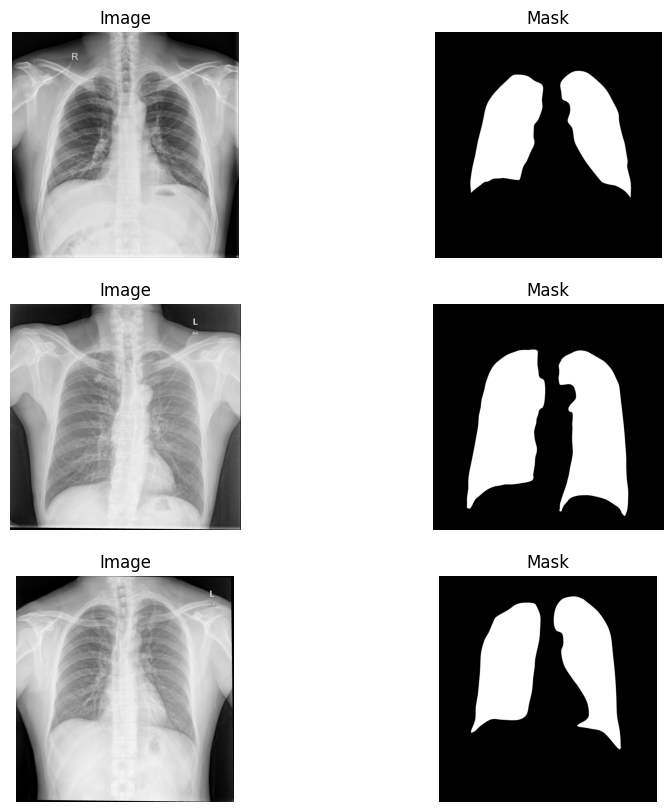

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Paths
image_path = '/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/image'
mask_path = '/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/mask'

# List of files
image_files = sorted(os.listdir(image_path))
mask_files = sorted(os.listdir(mask_path))

# Function to load image and mask
def load_image_and_mask(index):
    image = cv2.imread(os.path.join(image_path, image_files[index]), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(os.path.join(mask_path, mask_files[index]), cv2.IMREAD_GRAYSCALE)
    return image, mask

# Visualize a few images and masks
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

for i in range(3):
    image, mask = load_image_and_mask(i)
    
    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title('Mask')
    axes[i, 1].axis('off')

plt.show()

In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import glob

# Define paths
image_path = "/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/image"
mask_path = "/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/mask"

# Output directories (Create if not exist)
output_image_path = "/kaggle/working/resized_images"
output_mask_path = "/kaggle/working/resized_masks"

os.makedirs(output_image_path, exist_ok=True)
os.makedirs(output_mask_path, exist_ok=True)

# Set new resolution
NEW_SIZE = (512, 512)  # You can change this if needed

# Function to resize images
def resize_and_save(input_dir, output_dir):
    files = glob.glob(os.path.join(input_dir, "*"))
    for file in tqdm(files, desc=f"Resizing {input_dir}"):
        img = cv2.imread(file, cv2.IMREAD_UNCHANGED)  # Read image as is
        img_resized = cv2.resize(img, NEW_SIZE, interpolation=cv2.INTER_CUBIC)  # Use cubic interpolation for quality
        filename = os.path.basename(file)
        cv2.imwrite(os.path.join(output_dir, filename), img_resized)

# Resize images & masks
resize_and_save(image_path, output_image_path)
resize_and_save(mask_path, output_mask_path)

print("✅ Resizing completed! Resized images are stored in '/kaggle/working/resized_images' and masks in '/kaggle/working/resized_masks'")

Resizing /kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/image: 100%|██████████| 704/704 [01:48<00:00,  6.48it/s]
Resizing /kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/mask: 100%|██████████| 704/704 [00:29<00:00, 23.64it/s]

✅ Resizing completed! Resized images are stored in '/kaggle/working/resized_images' and masks in '/kaggle/working/resized_masks'


In [4]:
import os
import cv2
import albumentations as A
from tqdm import tqdm
import random
import numpy as np

# Input paths
image_dir = '/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/image'
mask_dir = '/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/mask'

# Output paths
save_image_dir = '/kaggle/working/expanded_dataset/image'
save_mask_dir = '/kaggle/working/expanded_dataset/mask'

# Create output directories if they don't exist
os.makedirs(save_image_dir, exist_ok=True)
os.makedirs(save_mask_dir, exist_ok=True)

# Get sorted lists of filenames
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))
assert len(image_files) == len(mask_files), "The number of images and masks must be equal."

# Define the augmentation pipeline
transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.2),
    A.GridDistortion(p=0.4),
    A.ElasticTransform(alpha=120, sigma=6, alpha_affine=3, p=0.4)
])

# Target total images to generate
target_total = 8000
total_generated = 0

print("🟢 Generating 8000 images with proper binary masks now...")

# Use a round-robin loop to ensure every image is used evenly
while total_generated < target_total:
    # Use round-robin indexing across all original images
    idx = total_generated % len(image_files)
    
    # Construct full paths for the current image and its corresponding mask
    img_path = os.path.join(image_dir, image_files[idx])
    msk_path = os.path.join(mask_dir, mask_files[idx])
    
    # Read image (color) and mask (grayscale)
    image = cv2.imread(img_path)
    mask = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)
    
    # Apply augmentation transform (both image and mask)
    augmented = transform(image=image, mask=mask)
    aug_image = augmented['image']
    aug_mask = augmented['mask']
    
    # Ensure the mask is binary: threshold the mask so that values >127 become 255, else 0.
    aug_mask = (aug_mask > 127).astype(np.uint8) * 255
    
    # Save the augmented image and its corresponding mask with the same filename
    filename = f"{total_generated+1:05d}.png"
    cv2.imwrite(os.path.join(save_image_dir, filename), aug_image)
    cv2.imwrite(os.path.join(save_mask_dir, filename), aug_mask)
    
    total_generated += 1

print("✅ Dataset expansion complete!")
print(f"Total Images Generated: {len(os.listdir(save_image_dir))}")
print(f"Total Masks Generated: {len(os.listdir(save_mask_dir))}")

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
<ipython-input-4-87420069f6f1>:34: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=120, sigma=6, alpha_affine=3, p=0.4)


🟢 Generating 8000 images with proper binary masks now...
✅ Dataset expansion complete!
Total Images Generated: 8000
Total Masks Generated: 8000


In [5]:
import os

# Paths to augmented images and masks
aug_image_dir = "/kaggle/working/expanded_dataset/image"
aug_mask_dir = "/kaggle/working/expanded_dataset/mask"

# Count total images and masks
total_images = len(os.listdir(aug_image_dir))
total_masks = len(os.listdir(aug_mask_dir))

print(f"Total Images: {total_images}")
print(f"Total Masks: {total_masks}")


Total Images: 8000
Total Masks: 8000


In [6]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# Define paths
aug_image_dir = "/kaggle/working/expanded_dataset/image"
aug_mask_dir = "/kaggle/working/expanded_dataset/mask"

# Output directories
output_dir = "/kaggle/working/split_dataset"
train_img_dir = os.path.join(output_dir, "train/image")
train_mask_dir = os.path.join(output_dir, "train/mask")
val_img_dir = os.path.join(output_dir, "val/image")
val_mask_dir = os.path.join(output_dir, "val/mask")
test_img_dir = os.path.join(output_dir, "test/image")
test_mask_dir = os.path.join(output_dir, "test/mask")

# Create directories if they don't exist
for folder in [train_img_dir, train_mask_dir, val_img_dir, val_mask_dir, test_img_dir, test_mask_dir]:
    os.makedirs(folder, exist_ok=True)

# Get sorted lists of images and masks
image_files = sorted(os.listdir(aug_image_dir))
mask_files = sorted(os.listdir(aug_mask_dir))

# Ensure images and masks match
image_files = [img for img in image_files if img in mask_files]
mask_files = [mask for mask in mask_files if mask in image_files]

# Shuffle data
combined = list(zip(image_files, mask_files))
random.shuffle(combined)
image_files, mask_files = zip(*combined)

# Split data (70% train, 15% val, 15% test)
train_images, temp_images, train_masks, temp_masks = train_test_split(image_files, mask_files, test_size=0.30, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(temp_images, temp_masks, test_size=0.50, random_state=42)

# Function to move files
def move_files(file_list, src_folder, dest_folder):
    for file in file_list:
        shutil.move(os.path.join(src_folder, file), os.path.join(dest_folder, file))

# Move files to respective directories
move_files(train_images, aug_image_dir, train_img_dir)
move_files(train_masks, aug_mask_dir, train_mask_dir)
move_files(val_images, aug_image_dir, val_img_dir)
move_files(val_masks, aug_mask_dir, val_mask_dir)
move_files(test_images, aug_image_dir, test_img_dir)
move_files(test_masks, aug_mask_dir, test_mask_dir)

print(f"✅ Dataset successfully split!")
print(f"🔹 Train: {len(train_images)} images")
print(f"🔹 Validation: {len(val_images)} images")
print(f"🔹 Test: {len(test_images)} images")

✅ Dataset successfully split!
🔹 Train: 5600 images
🔹 Validation: 1200 images
🔹 Test: 1200 images


In [7]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Define Custom Dataset Class
class LungSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])
        
        image = Image.open(img_path).convert("L")  # Convert to grayscale
        mask = Image.open(mask_path).convert("L")  # Convert to grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512)),  # Resize images if needed
])

# Define Paths
train_image_dir = "/kaggle/working/split_dataset/train/image"
train_mask_dir = "/kaggle/working/split_dataset/train/mask"
val_image_dir = "/kaggle/working/split_dataset/val/image"
val_mask_dir = "/kaggle/working/split_dataset/val/mask"

# Create Dataset Instances
train_dataset = LungSegmentationDataset(train_image_dir, train_mask_dir, transform)
val_dataset = LungSegmentationDataset(val_image_dir, val_mask_dir, transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Verify a Batch
sample_images, sample_masks = next(iter(train_loader))
print("Sample Image Shape:", sample_images.shape)
print("Sample Mask Shape:", sample_masks.shape)

Sample Image Shape: torch.Size([16, 1, 512, 512])
Sample Mask Shape: torch.Size([16, 1, 512, 512])


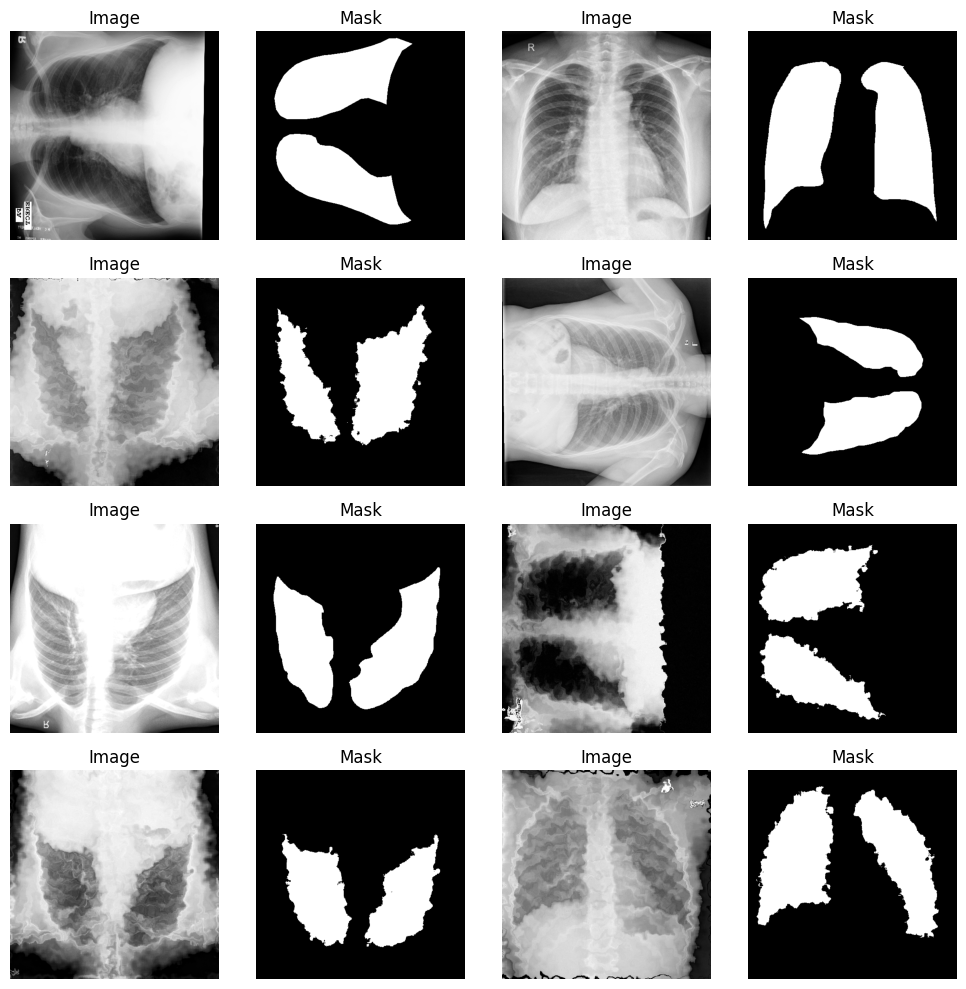

In [8]:
import matplotlib.pyplot as plt

# Get a batch of training data
sample_images, sample_masks = next(iter(train_loader))  

# Convert tensors to NumPy arrays for visualization
sample_images = sample_images.squeeze(1).numpy()  
sample_masks = sample_masks.squeeze(1).numpy()  

# Plot some sample images and their corresponding masks
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i % 2 == 0:  # Show image
        ax.imshow(sample_images[i // 2], cmap='gray')
        ax.set_title("Image")
    else:  # Show corresponding mask
        ax.imshow(sample_masks[i // 2], cmap='gray')
        ax.set_title("Mask")
    
    ax.axis('off')

plt.tight_layout()
plt.show()


### Unet

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        def up_block(in_c, out_c):
            return nn.Sequential(
                nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2),
                conv_block(out_c * 2, out_c)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = conv_block(512, 1024)

        self.up4 = up_block(1024, 512)
        self.up3 = up_block(512, 256)
        self.up2 = up_block(256, 128)
        self.up1 = up_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        up4 = self.up4[0](bottleneck)
        up4 = torch.cat([up4, enc4], dim=1)
        up4 = self.up4[1](up4)

        up3 = self.up3[0](up4)
        up3 = torch.cat([up3, enc3], dim=1)
        up3 = self.up3[1](up3)

        up2 = self.up2[0](up3)
        up2 = torch.cat([up2, enc2], dim=1)
        up2 = self.up2[1](up2)

        up1 = self.up1[0](up2)
        up1 = torch.cat([up1, enc1], dim=1)
        up1 = self.up1[1](up1)

        return torch.sigmoid(self.final(up1))

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
print(model)

UNet(
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
import os
from tqdm import tqdm

# ============================
# Dataset Class
# ============================
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_list = sorted(os.listdir(image_dir))
        self.mask_list = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_list[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_list[idx])

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, (256, 256))
        mask = cv2.resize(mask, (256, 256))

        image = np.expand_dims(image, axis=0)  # Add channel dimension (C, H, W)
        mask = np.expand_dims(mask, axis=0)

        image = image / 255.0  # Normalize to [0,1]
        mask = mask / 255.0

        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        return image, mask

# ============================
# U-Net Model
# ============================
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            )

        self.enc1 = conv_block(1, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.bottleneck = conv_block(512, 1024)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        bottleneck = self.bottleneck(self.pool(enc4))

        up4 = self.up4(bottleneck)
        up4 = torch.cat([up4, enc4], dim=1)
        dec4 = self.dec4(up4)

        up3 = self.up3(dec4)
        up3 = torch.cat([up3, enc3], dim=1)
        dec3 = self.dec3(up3)

        up2 = self.up2(dec3)
        up2 = torch.cat([up2, enc2], dim=1)
        dec2 = self.dec2(up2)

        up1 = self.up1(dec2)
        up1 = torch.cat([up1, enc1], dim=1)
        dec1 = self.dec1(up1)

        return self.final(dec1)

# ============================
# Custom Loss Function (BCE + Dice Loss)
# ============================
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, smooth=1e-5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.bce = nn.BCEWithLogitsLoss()
        self.smooth = smooth

    def forward(self, preds, targets):
        # Compute BCE loss
        bce_loss = self.bce(preds, targets)

        # Compute Dice loss: apply sigmoid to preds first.
        preds = torch.sigmoid(preds)
        intersection = (preds * targets).sum(dim=(2, 3))
        union = torch.sum(preds, dim=(2, 3)) + torch.sum(targets, dim=(2, 3))
        dice_loss = 1 - (2.0 * intersection + self.smooth) / (union + self.smooth)
        dice_loss = dice_loss.mean()

        return self.alpha * bce_loss + (1 - self.alpha) * dice_loss

# ============================
# Training Configuration
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

# Loss function and optimizer
criterion = CombinedLoss(alpha=0.5)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Load dataset
train_dataset = SegmentationDataset(image_dir="/kaggle/working/split_dataset/train/image", mask_dir="/kaggle/working/split_dataset/train/mask")
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# ============================
# Training Loop
# ============================
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

# ============================
# Saving Model
# ============================
torch.save(model.state_dict(), "unet_model.pth")
print("✅ Model saved successfully!")

Training Epoch 1/15: 100%|██████████| 350/350 [02:47<00:00,  2.09it/s]


Epoch 1/15 - Loss: 0.3389


Training Epoch 2/15: 100%|██████████| 350/350 [02:46<00:00,  2.10it/s]


Epoch 2/15 - Loss: 0.1303


Training Epoch 3/15: 100%|██████████| 350/350 [02:46<00:00,  2.10it/s]


Epoch 3/15 - Loss: 0.1001


Training Epoch 4/15: 100%|██████████| 350/350 [02:46<00:00,  2.10it/s]


Epoch 4/15 - Loss: 0.0895


Training Epoch 5/15: 100%|██████████| 350/350 [02:46<00:00,  2.10it/s]


Epoch 5/15 - Loss: 0.0812


Training Epoch 6/15: 100%|██████████| 350/350 [02:46<00:00,  2.10it/s]


Epoch 6/15 - Loss: 0.0754


Training Epoch 7/15: 100%|██████████| 350/350 [02:46<00:00,  2.10it/s]


Epoch 7/15 - Loss: 0.0713


Training Epoch 8/15: 100%|██████████| 350/350 [02:46<00:00,  2.10it/s]


Epoch 8/15 - Loss: 0.0672


Training Epoch 9/15: 100%|██████████| 350/350 [02:46<00:00,  2.10it/s]


Epoch 9/15 - Loss: 0.0646


Training Epoch 10/15: 100%|██████████| 350/350 [02:46<00:00,  2.11it/s]


Epoch 10/15 - Loss: 0.0611


Training Epoch 11/15: 100%|██████████| 350/350 [02:46<00:00,  2.10it/s]


Epoch 11/15 - Loss: 0.0605


Training Epoch 12/15: 100%|██████████| 350/350 [02:46<00:00,  2.11it/s]


Epoch 12/15 - Loss: 0.0579


Training Epoch 13/15: 100%|██████████| 350/350 [02:46<00:00,  2.10it/s]


Epoch 13/15 - Loss: 0.0555


Training Epoch 14/15: 100%|██████████| 350/350 [02:46<00:00,  2.11it/s]


Epoch 14/15 - Loss: 0.0547


Training Epoch 15/15: 100%|██████████| 350/350 [02:46<00:00,  2.11it/s]


Epoch 15/15 - Loss: 0.0537
✅ Model saved successfully!


<ipython-input-11-9693e7ae63bf>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet_model.pth", map_location=device))


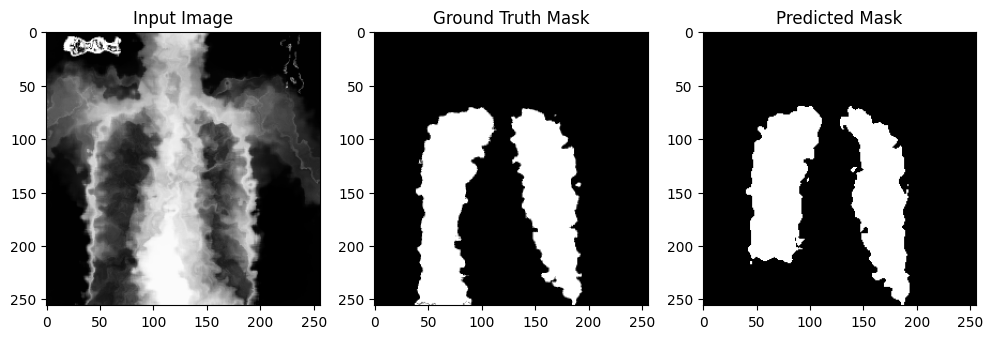

In [11]:
import matplotlib.pyplot as plt

# Load Trained Model
model.load_state_dict(torch.load("unet_model.pth", map_location=device))
model.eval()

# Load a sample test image
test_dataset = SegmentationDataset(image_dir="/kaggle/working/split_dataset/test/image", mask_dir="/kaggle/working/split_dataset/test/mask")
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Get a single test sample
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)
        preds = torch.sigmoid(preds)  # Convert logits to probabilities
        preds = (preds > 0.5).float()  # Convert to binary mask

        # Convert to numpy for visualization
        img = images.cpu().numpy()[0, 0]  # Grayscale image
        mask = masks.cpu().numpy()[0, 0]
        pred_mask = preds.cpu().numpy()[0, 0]

        # Plot results
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].imshow(img, cmap='gray')
        ax[0].set_title("Input Image")
        ax[1].imshow(mask, cmap='gray')
        ax[1].set_title("Ground Truth Mask")
        ax[2].imshow(pred_mask, cmap='gray')
        ax[2].set_title("Predicted Mask")
        plt.show()
        break  # Only show one sample


In [12]:
def dice_score(preds, targets, smooth=1e-5):
    intersection = (preds * targets).sum(dim=(2, 3))
    union = torch.sum(preds, dim=(2, 3)) + torch.sum(targets, dim=(2, 3))
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice.mean().item()

# Evaluate on test data
model.eval()
total_dice = 0
num_samples = 0

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        preds = model(images)
        preds = torch.sigmoid(preds)
        preds = (preds > 0.5).float()  # Binarize

        total_dice += dice_score(preds, masks)
        num_samples += 1

avg_dice = total_dice / num_samples
print(f"🟢 Average Dice Score on Test Set: {avg_dice:.4f}")

🟢 Average Dice Score on Test Set: 0.9554
